  0%|          | 0/11 [00:00<?, ?it/s]

epock 0 train_loss: 0.05029 test_loss: 0.04996
epock 1 train_loss: 0.02416 test_loss: 0.00910
epock 2 train_loss: 0.00749 test_loss: 0.00607
epock 3 train_loss: 0.00454 test_loss: 0.00367
epock 4 train_loss: 0.00314 test_loss: 0.00263
epock 5 train_loss: 0.00230 test_loss: 0.00196
epock 6 train_loss: 0.00180 test_loss: 0.00160
epock 7 train_loss: 0.00149 test_loss: 0.00150
epock 8 train_loss: 0.00127 test_loss: 0.00117
epock 9 train_loss: 0.00108 test_loss: 0.00097
epock 10 train_loss: 0.00092 test_loss: 0.00083


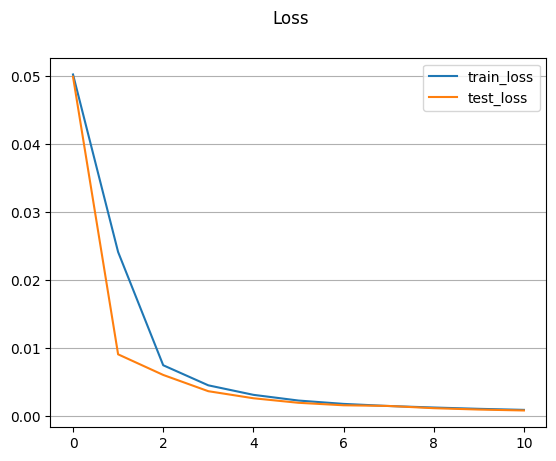

In [ ]:
# グラフをインラインで表示するためのマジックコマンド
%matplotlib inline

# 必要なライブラリをインポート
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets, transforms

# GPUが利用可能であればCUDAデバイスを使用し、そうでなければCPUを使用
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# MNISTデータセットのダウンロードとトレーニング、テストデータの変換
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# トレーニングデータとテストデータの前処理
x_train = train_dataset.data.reshape(-1, 784).float() / 255
y_train = F.one_hot(train_dataset.targets, 10).float()
x_test = test_dataset.data.reshape(-1, 784).float() / 255
y_test = F.one_hot(test_dataset.targets, 10).float()

# カスタムデータセットクラスの定義
class DataSet(Dataset):
    def __init__(self, data, transform=False):
        self.X = data[0]
        self.y = data[1]
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        img = self.X[index].view(28, 28)
        label = self.y[index]
        if self.transform:
            img = transforms.ToPILImage()(img)
            img = self.transform(img)
        return img, label

# 画像データの正規化のための変換関数を定義
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))] 
)

# トレーニングデータとテストデータセットの作成
trainset = DataSet([x_train,y_train], transform=transform)
testset = DataSet([x_test,y_test], transform=transform)

# バッチサイズの定義とデータローダーの作成
batch_size = 256
trainloader = DataLoader(trainset, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=0)

# 残差層クラスの定義
class ResidualLayer(nn.Module):
    # コンストラクタで畳み込み層を定義
    def __init__(self, in_dim, h_dim, res_h_dim):
        super(ResidualLayer, self).__init__()
        self.res_block = nn.Sequential(
            nn.ReLU(True), 
            nn.Conv2d(in_dim, res_h_dim, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(res_h_dim, h_dim, kernel_size=1, stride=1, bias=False)
        )
    
    # フォワードパスで残差接続を適用
    def forward(self, x):
        x = x + self.res_block(x)
        return x

# 残差スタッククラスの定義
class ResidualStack(nn.Module):
    # コンストラクタで指定された数の残差層をスタック
    def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
        super(ResidualStack, self).__init__()
        self.n_res_layers = n_res_layers
        self.stack = nn.ModuleList(
            [ResidualLayer(in_dim, h_dim, res_h_dim)]*n_res_layers)

    # フォワードパスでスタックを通過させる
    def forward(self, x):
        for layer in self.stack:
            x = layer(x)
        x = F.relu(x)
        return x

# エンコーダクラスの定義
class Encoder(nn.Module):
    # コンストラクタで畳み込み層と残差スタックを定義
    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Encoder, self).__init__()
        kernel = 4
        stride = 2
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_dim, h_dim // 2, kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim // 2, h_dim, kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim, h_dim, kernel_size=kernel-1, stride=stride-1, padding=1),
            ResidualStack(h_dim, h_dim, res_h_dim, n_res_layers)
        )

    # フォワードパスで画像を特徴ベクトルにエンコード
    def forward(self, x):
        return self.conv_stack(x)

# ベクトル量子化クラスの定義
class VectorQuantizer(nn.Module):
    # コンストラクタでエンベッディング層を定義
    def __init__(self, n_e, e_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta
        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)

    # フォワードパスで入力ベクトルを最も近いエンベッディングベクトルに量子化
    def forward(self, z):
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.e_dim)
        d = torch.sum(z_flattened**2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.matmul(z_flattened, self.embedding.weight.t())
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
        min_encodings = torch.zeros(
            min_encoding_indices.shape[0], self.n_e).to(device)
        min_encodings.scatter_(1, min_encoding_indices, 1)
        z_q = torch.matmul(min_encodings, self.embedding.weight).view(z.shape)
        loss = torch.mean((z.detach() - z_q)**2) + \
            self.beta * torch.mean((z - z_q.detach()) ** 2)
        z_q = z + (z_q - z).detach()
        z_q = z_q.permute(0, 3, 1, 2).contiguous()
        return loss, z_q, min_encodings, min_encoding_indices

# デコーダクラスの定義
class Decoder(nn.Module):
    # コンストラクタで逆畳み込み層と残差スタックを定義
    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Decoder, self).__init__()
        kernel = 4
        stride = 2
        self.inverse_conv_stack = nn.Sequential(
            nn.ConvTranspose2d(in_dim, h_dim, kernel_size=kernel-1, stride=stride-1, padding=1),
            ResidualStack(h_dim, h_dim, res_h_dim, n_res_layers),
            nn.ConvTranspose2d(h_dim, h_dim // 2, kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim//2, 1, kernel_size=kernel, stride=stride, padding=1)
        )

    # フォワードパスで特徴ベクトルから画像をデコード
    def forward(self, x):
        return self.inverse_conv_stack(x)

# VQ-VAEモデルクラスの定義
class VQVAE(nn.Module):
    # コンストラクタでエンコーダ、ベクトル量子化層、デコーダを定義
    def __init__(self, h_dim, res_h_dim, n_res_layers, n_embeddings, embedding_dim, beta):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(1, h_dim, n_res_layers, res_h_dim)
        self.pre_quantization_conv = nn.Conv2d(h_dim, embedding_dim, kernel_size=1, stride=1)
        self.vector_quantization = VectorQuantizer(n_embeddings, embedding_dim, beta)
        self.decoder = Decoder(embedding_dim, h_dim, n_res_layers, res_h_dim)

    # フォワードパスで画像をエンコード、量子化、デコード
    def forward(self, x):
        z_e = self.encoder(x)
        z_e = self.pre_quantization_conv(z_e)
        embedding_loss, z_q, _ , _ = self.vector_quantization(z_e)
        x_hat = self.decoder(z_q)
        return embedding_loss, x_hat

# エポック数の定義
epoch = 0
max_epoch = 10

# VQ-VAEモデルのインスタンス作成
model = VQVAE(128, 32, 2, 512, 64, .25)

# 最適化アルゴリズムの定義
opt = optim.Adam(model.parameters(), lr=3e-4, betas=(0.5, 0.9))

# トレーニングとテストのロスを記録するリスト
train_loss_log=[]
test_loss_log=[]

# エポックごとのトレーニングとテストループ
for i in tqdm(range(epoch,max_epoch+1)):
    train_loss=0
    test_loss=0
    model=model.to(device)
    
    # トレーニングモードでモデルを設定
    model.train()
    for (img, _) in trainloader:
        img = img.to(device,dtype=torch.float)
        opt.zero_grad()
        embedding_loss, x_hat = model(img)
        recon_loss = nn.MSELoss()(x_hat, img)
        loss = recon_loss + embedding_loss
        train_loss += loss.item()
        loss.backward()
        opt.step()
    
    # 評価モードでモデルを設定
    model.eval()
    for (img_t, _) in testloader:
        img = img.to(device,dtype=torch.float)
        embedding_loss, x_hat = model(img)
        recon_loss = nn.MSELoss()(x_hat, img)
        loss = recon_loss + embedding_loss
        test_loss += loss.item()
    
    # エポックごとのロスを計算し、表示
    train_loss /= len(trainloader.dataset)
    test_loss /= len(testloader.dataset)
    print('epock %d train_loss: %.5f test_loss: %.5f'%(i,train_loss,test_loss))
    train_loss_log.append(train_loss)
    test_loss_log.append(test_loss)

    # 最終エポックでモデルを保存
    if i==(max_epoch):
        torch.save({'param':model.to('cpu').state_dict(),
                    'opt':opt.state_dict(),
                    'epoch': i},
                    'VQVAE_local.pth')

# ロスのプロット
plt.suptitle('Loss')
plt.plot(train_loss_log, label='train_loss')
plt.plot(test_loss_log, label='test_loss')
plt.grid(axis='y')
plt.legend()
plt.show()

In [1]:
import random  # ランダムな整数を生成するためのライブラリのインポート

# 保存されたモデルのファイルパス
model_path = "VQVAE_local.pth"
# VQVAEモデルのインスタンスの作成
model = VQVAE(128, 32, 2, 512, 64, .25)
# 保存されたモデルのパラメータをロード
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['param'])
# モデルを適切なデバイス（GPUまたはCPU）に移動
model = model.to(device)
# テストデータローダーから最初のバッチを取得し、適切なデバイスに移動
img_batch = next(iter(testloader))[0].to(device)

# バッチからランダムにインデックスを選ぶ
random_index = random.randint(0, img_batch.size(0) - 1)

# 選ばれた画像をバッチに変換（次元を追加）
img = img_batch[random_index].unsqueeze(0)
# モデルを通じて画像をエンコードし、デコード
embedding_loss, x_hat = model(img)
# 出力画像をCPUに移動し、NumPy配列に変換
pred = x_hat[0].to('cpu').detach().numpy().reshape(28, 28, 1)
# 元の画像をCPUに移動し、NumPy配列に変換
origin = img[0].to('cpu').detach().numpy().reshape(28, 28, 1)

# 元の画像を表示
plt.subplot(211)
plt.imshow(origin, cmap="gray")
plt.xticks([])  # x軸の目盛りを非表示
plt.yticks([])  # y軸の目盛りを非表示
plt.text(x=3, y=2, s="original image", c="red")  # テキストラベルの追加

# 出力画像を表示
plt.subplot(212)
plt.imshow(pred, cmap="gray")
plt.text(x=3, y=2, s="output image", c="red")  # テキストラベルの追加
plt.xticks([])  # x軸の目盛りを非表示
plt.yticks([])  # y軸の目盛りを非表示
plt.show()  # グラフの表示

NameError: name 'VQVAE' is not defined